# Setup

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pystan
import pickle
from hashlib import md5
from pathlib import Path

In [4]:
plt.style.use("ggplot")

In [334]:
def _validate_dates(dates):
    previous_date = dates[0]
    for date in dates[1:]:
        timedelta = (date - previous_date)
        assert timedelta.days == 1, str(timedelta)
        previous_date = date

def read_data_dict():
    filepath = "Casos_Diarios_Estado_Nacional_Confirmados_20200808.csv"
    df = pd.read_csv(filepath, index_col="nombre").drop("Nacional")
    y = df.filter(regex=("\d{2}-\d{2}-\d{4}")).transpose().astype(int)
    # Drop the last week of data as it is clearly incomplete
    y = y.iloc[:-7]
    training_dates = pd.to_datetime(y.index, format="%d-%m-%Y")
    y.index = training_dates
    training_dates_no_weekends = training_dates[~training_dates.weekday.isin([5, 6])]
    y = y.loc[training_dates_no_weekends, :]
    numbered_dates = (y.index - y.index[0]).days + 1 #Start counting at day=1
    poblacion = df.poblacion
    is_observed = (y != 0).astype(int)
    data = {
        "n_dates": len(y),
        "n_states": y.shape[1],
        "y": y.values,
        "is_observed": is_observed.values,
        "dates": numbered_dates,
        "pop": poblacion.astype(int).values,
        "n_future": 250, # Number of days to forecast
    }
    
    coordinates = {
        "state": list(y.columns),
        "date": training_dates_no_weekends,
        "forecast_date": pd.date_range(
            start=training_dates.min(),
            end=training_dates.max() + pd.Timedelta("250d"),
            freq="D",
        )
    }
    
    return data, coordinates


def tsplot(x, y, n=20, percentile_min=2.5, percentile_max=97.5, color='gray', plot_mean=False, plot_median=False, line_color='k', ax=None, **kwargs):
    # calculate the lower and upper percentile groups, skipping 50 percentile
    perc1 = np.percentile(y, np.linspace(percentile_min, 50, num=n, endpoint=False), axis=0)
    perc2 = np.percentile(y, np.linspace(50, percentile_max, num=n+1)[1:], axis=0)

    if 'alpha' in kwargs:
        alpha = kwargs.pop('alpha')
    else:
        alpha = 1/n
    
    if ax is None:
        ax = plt.gca()
    # fill lower and upper percentile groups
    for p1, p2 in zip(perc1, perc2):
        ax.fill_between(x, p1, p2, alpha=alpha, color=color, edgecolor=None)


    if plot_mean:
        ax.plot(x, np.mean(y, axis=0), color=line_color)

    if plot_median:
        ax.plot(x, np.median(y, axis=0), color=line_color)
    
    return ax

def PickledStanModel(file=None, **kwargs):
    filepath = Path(file)
    with open(filepath, "r") as f:
        model_code = f.read()

    code_hash = md5(model_code.encode('ascii')).hexdigest()
    cache_fn = filepath.parent / f"{filepath.stem}-{code_hash}.pkl" 
    
    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except:
        print(f"Pickling: {cache_fn!s}")
        sm = pystan.StanModel(model_code=model_code)
        with open(cache_fn, 'wb') as f:
            pickle.dump(sm, f)
    else:
        print("Using cached StanModel")
    return sm

In [336]:
model = PickledStanModel(file="covid_mx.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6003e0e731c4e4c057ac6660c429226d NOW.


Pickling: covid_mx-6003e0e731c4e4c057ac6660c429226d.pkl


In [337]:
def init(seed=None):
    if seed is not None:
        np.random.seed(seed)

    return dict(
        mu_alpha = np.random.normal(5.2, 0.5),
        mu_beta = np.random.normal(-3, 0.5),
        mu_gamma = np.random.normal(1.6, 0.5),
        mu_S = np.random.normal(-6, 0.5),
        log_alpha = [np.random.normal(5.2, 0.5) for _ in range(32)],
        log_beta = [np.random.normal(-3, 0.5) for _ in range(32)],
        log_gamma = [np.random.normal(1.6, 0.5) for _ in range(32)],
        logit_S = [np.random.normal(-6, 0.5) for _ in range(32)],
    )

In [342]:
debug = False
parameters = {
    "iter": 10 if debug else 1000,
    "init": init,
    "refresh": 10,
    "control": {
        "adapt_delta": 0.9,
        "max_treedepth": 12,
    }
}

# Run

In [343]:
data, coords = read_data_dict()

In [ ]:
samples = model.sampling(data, **parameters)

# Inspect divergences

In [285]:
import arviz as az

In [286]:
idata = az.from_pystan(
    samples,
    observed_data=['y', 'pop'],
    predictions=['y_pred',],
    dims={
        'y': ['date', 'state'],
        'y_pred': ['forecast_date', 'state'],
        'y_trend': ['forecast_date', 'state'],
        'pop': ['state'],
        'alpha': ['state'],
        'beta': ['state'],
        'nu': ['state'],
        'S': ['state'],
        'phi': ['state'],
        'dow': ['day'],
    },
    coords={
        **coords,
        **{
            'day': [d.day_name() for d in coords['date'][:6]],
        }
    },
)

/Users/omarfsosa/anaconda3/envs/stan/lib/python3.7/site-packages/arviz/plots/traceplot.py:254: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (32), generating only 20 plots
  UserWarning,


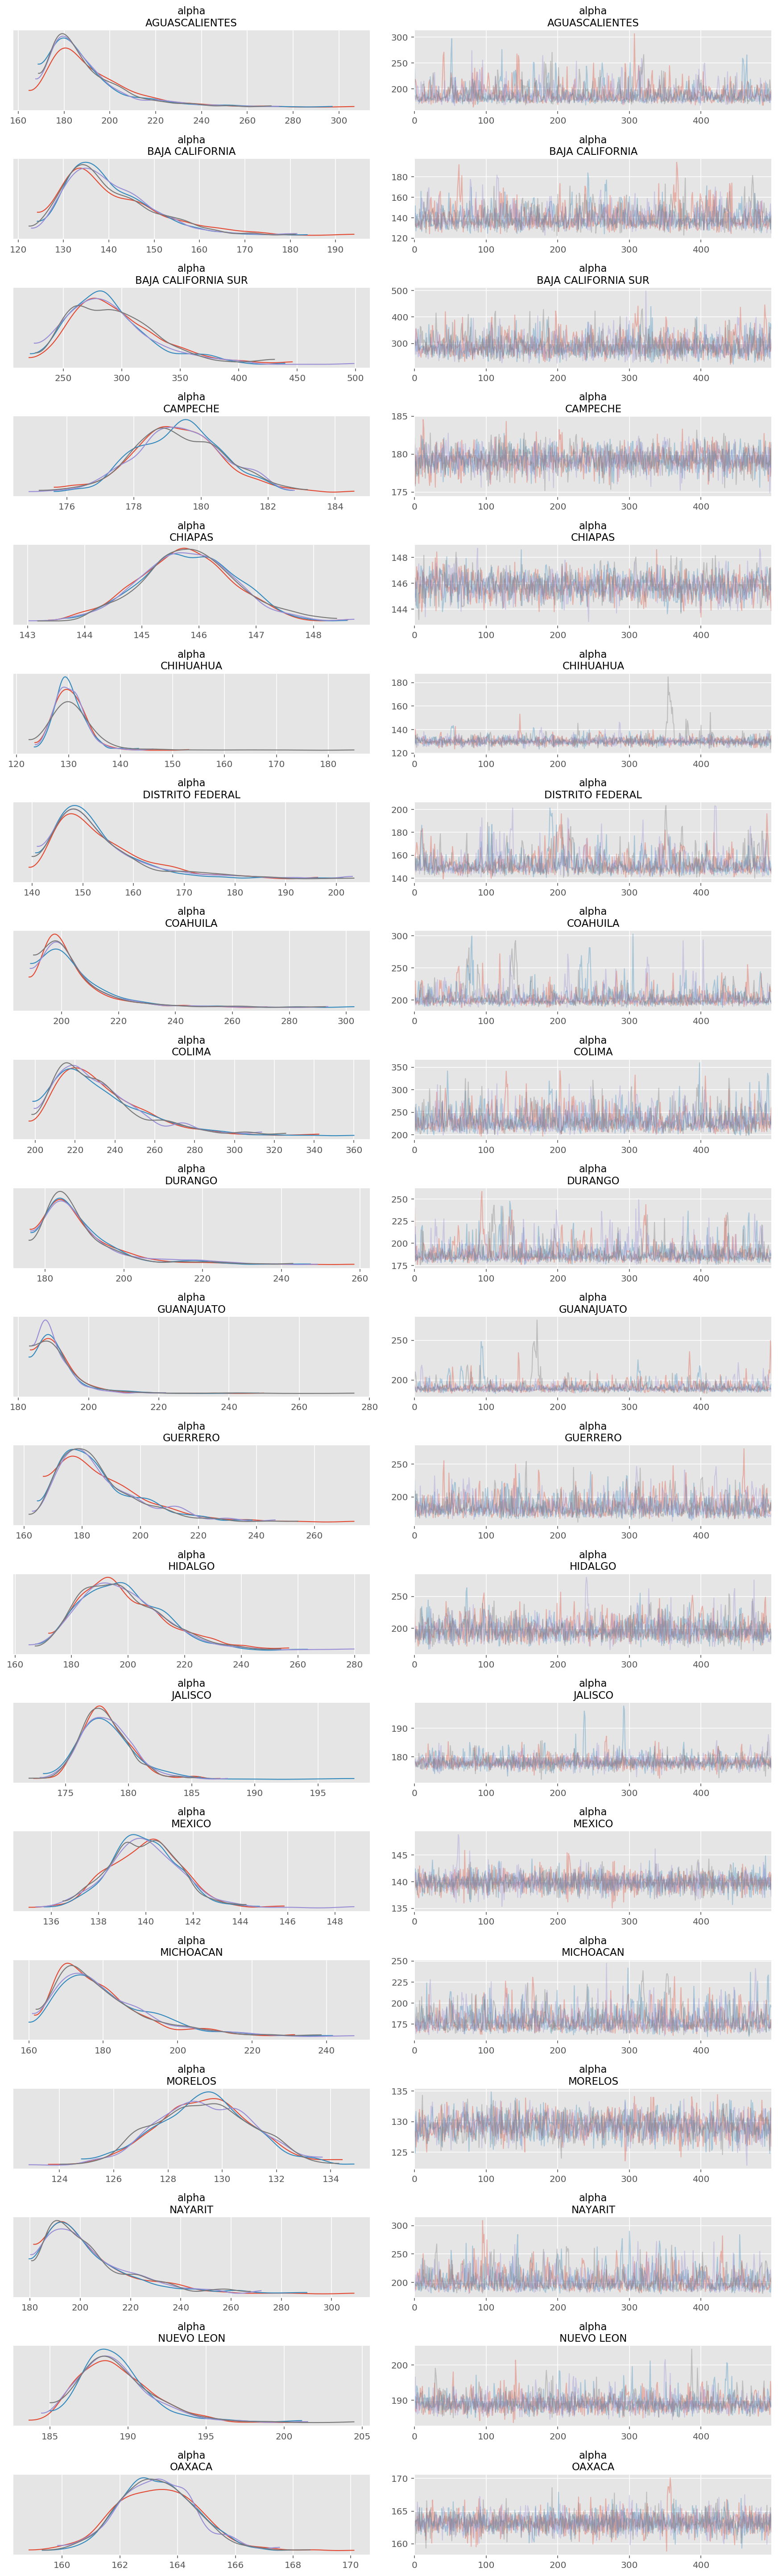

In [287]:
az.plot_trace(idata, var_names=["alpha"])
plt.show()

# Plot

In [288]:
order = np.argsort(np.max(data['y'], axis=0))[::-1]
sorted_states = [coords["state"][i] for i in order]
first_day_of_the_month = [d for d in coords["forecast_date"] if d.day == 1]
labels = [d.strftime("%b") for d in first_day_of_the_month]

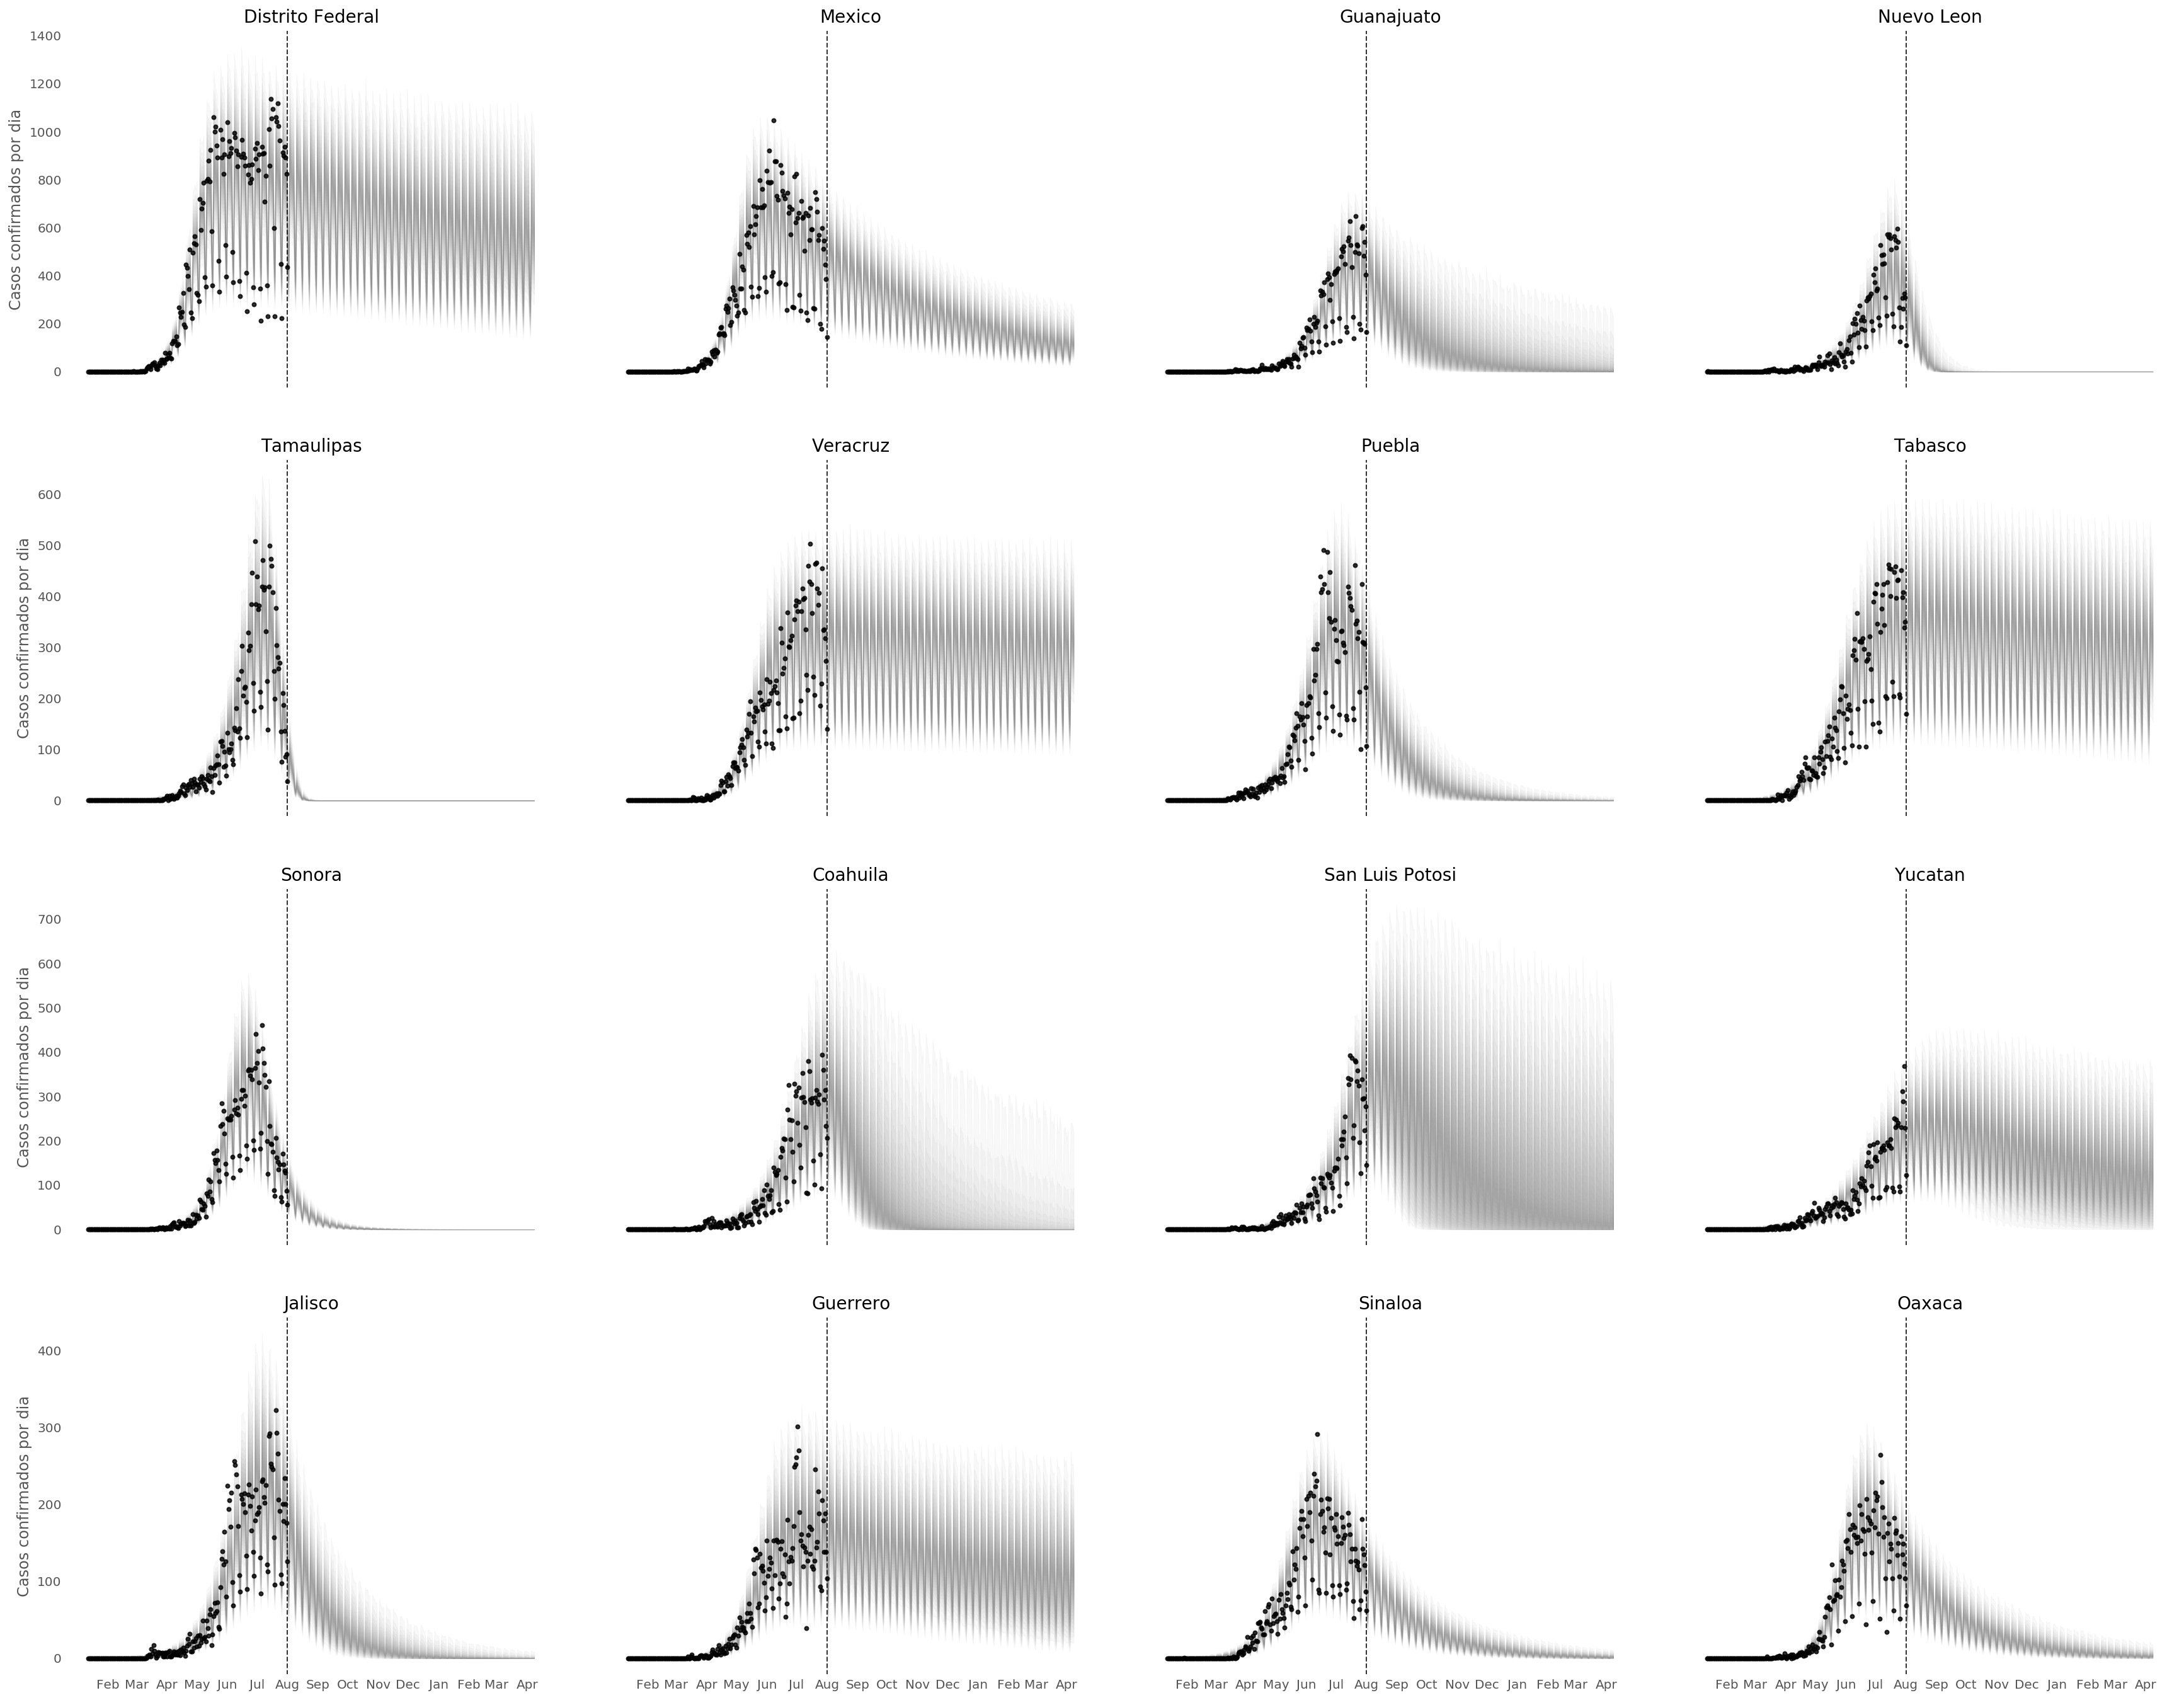

In [289]:
f, axes = plt.subplots(4, 4, figsize=(30, 4*6), sharey="row", sharex=True)
plt.subplots_adjust(hspace=0.2, wspace=0.1)
for ax, state in zip(axes.flatten(), sorted_states[:16]):
    stan_index = coords["state"].index(state)
    state_samples = samples.extract()["y_pred"][..., stan_index]
    ax.axvline(x=coords['date'][-1], linestyle='--', color='black', linewidth=1, alpha=0.8)
    ax.plot(coords['date'], data['y'][:, stan_index], marker='.', color='black', linestyle='none', alpha=0.8, label='datos')
    tsplot(coords['forecast_date'], state_samples[:, :], ax=ax)
    ax.set_title(state.lower().title(), fontsize=14)
    ax.set_facecolor('white')
    ax.tick_params(length=0)
    ax.set_xticks(first_day_of_the_month)
    ax.set_xticklabels(labels)
#     ax.set_ylim([0, 200])
for ax in axes[:, 0].flatten():
    plt.sca(ax)
    plt.ylabel("Casos confirmados por dia")
    
plt.show()

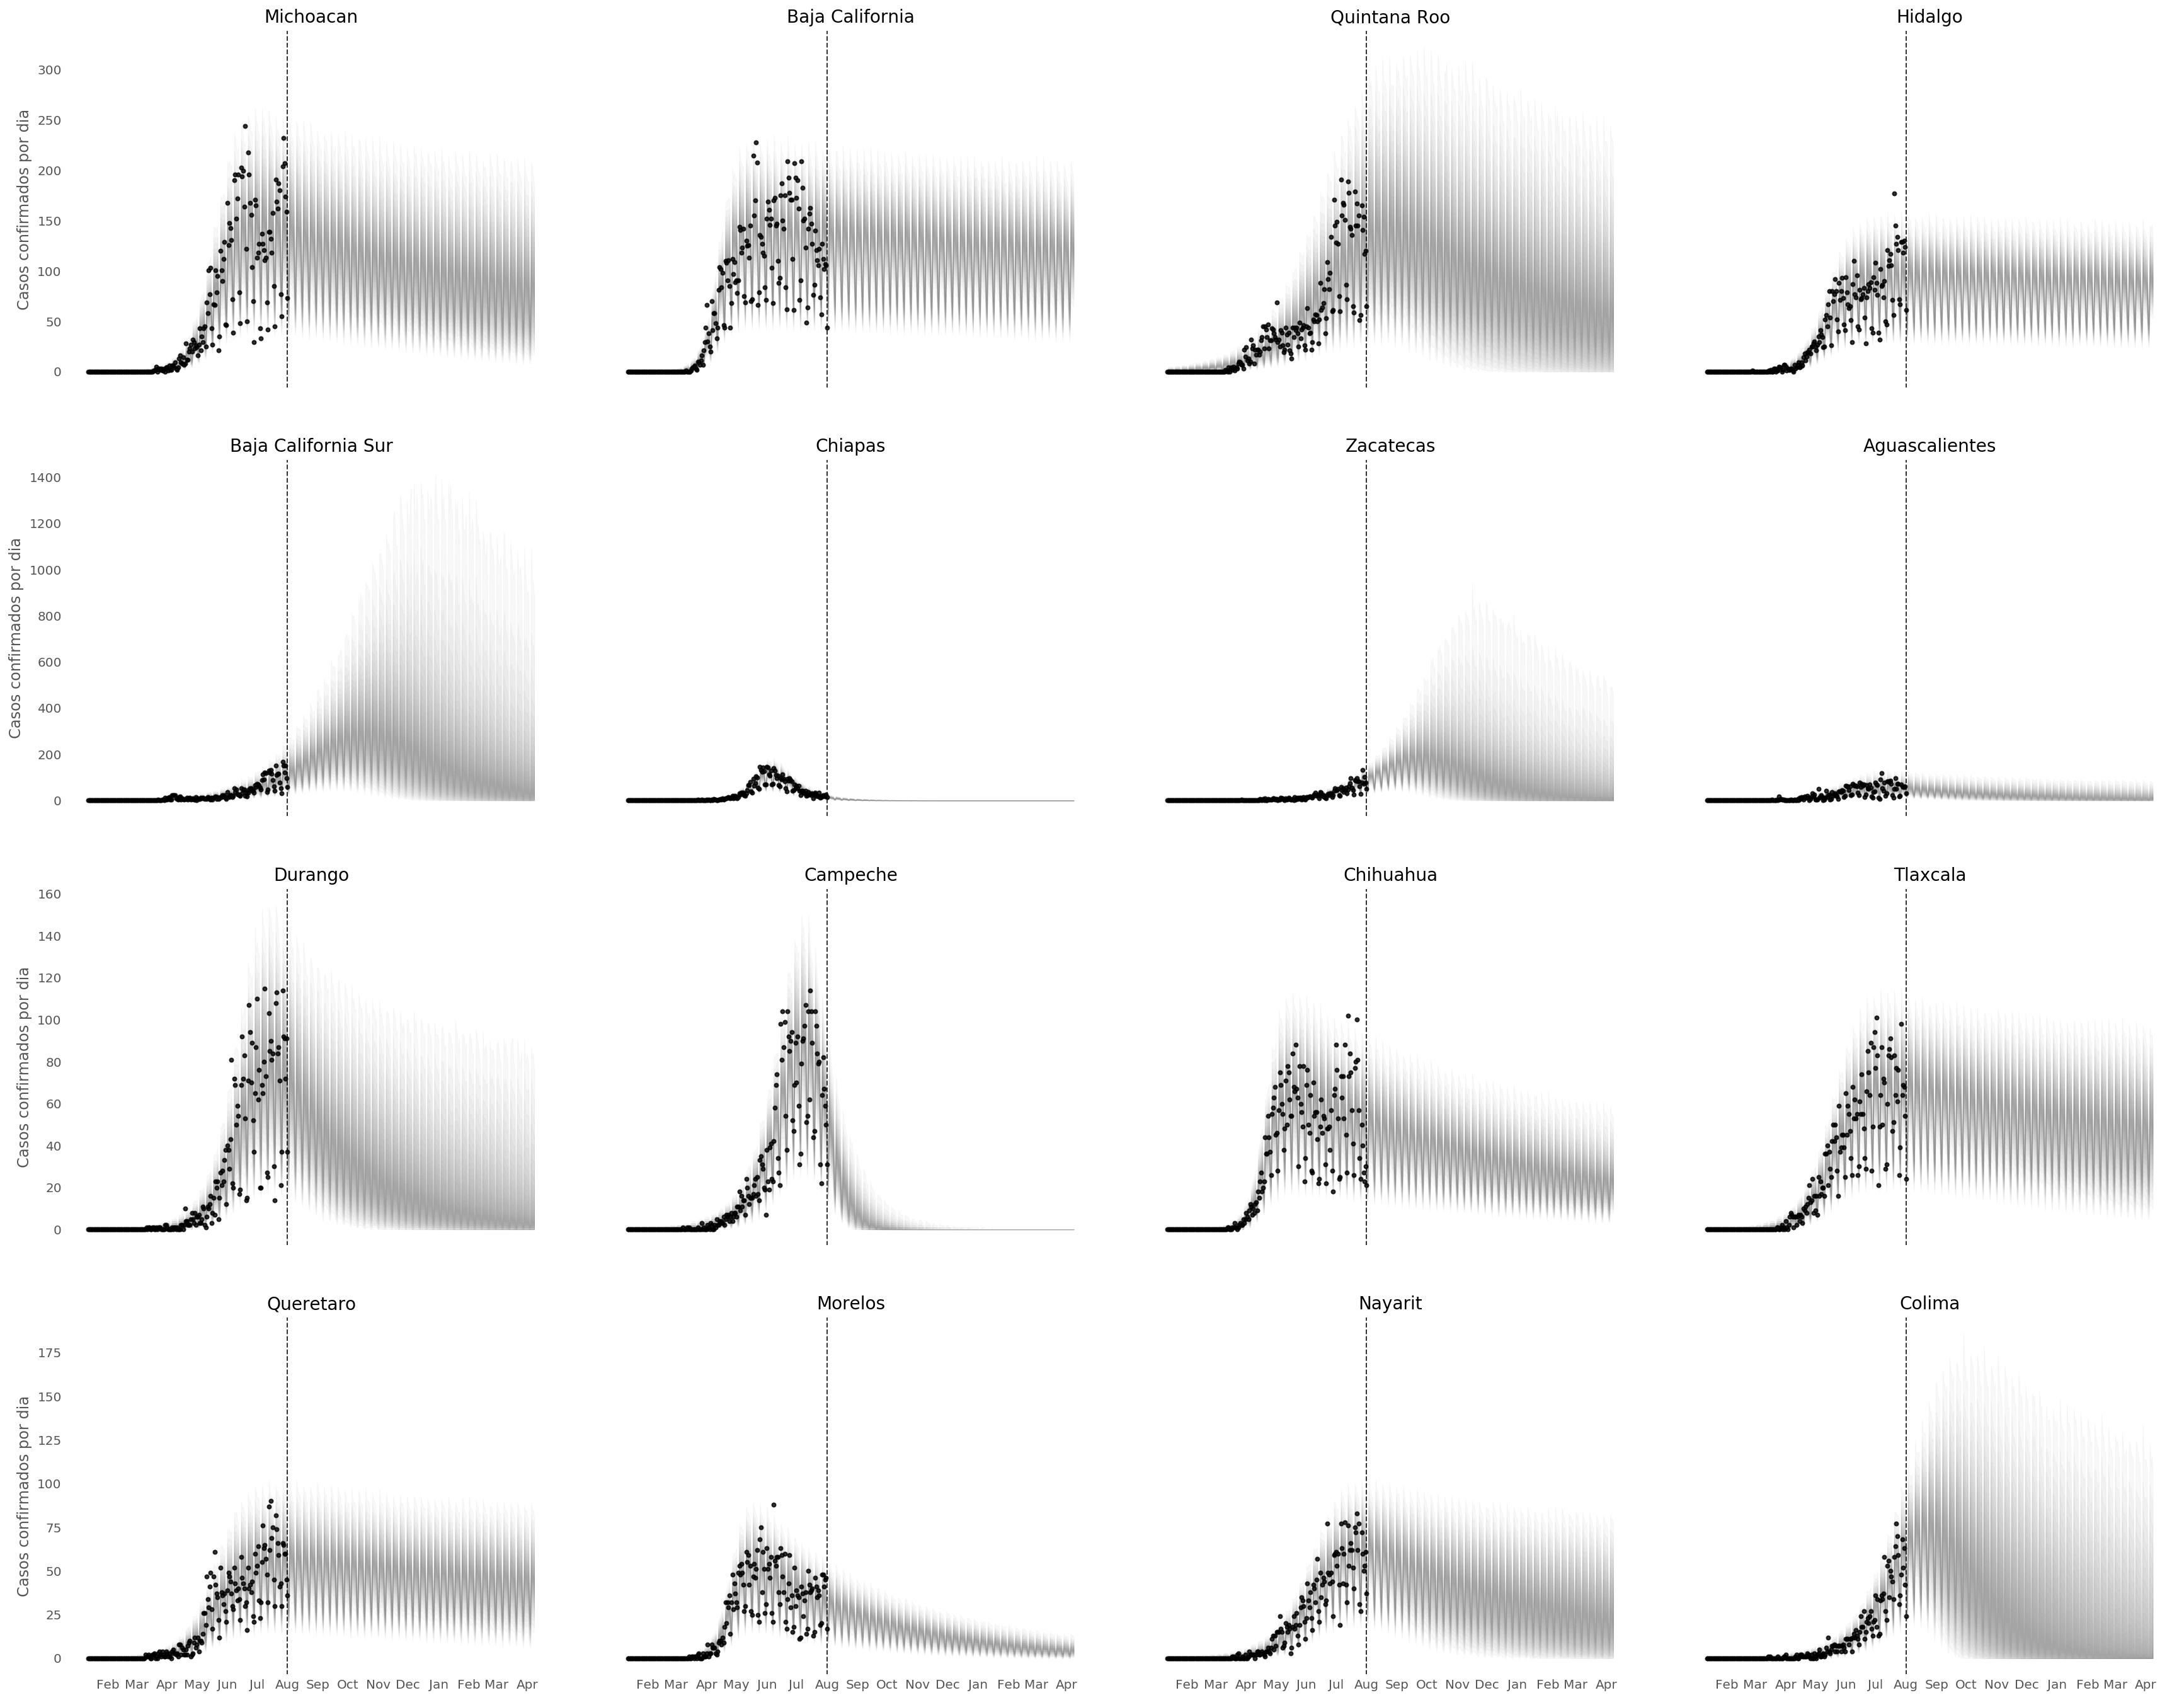

In [290]:
f, axes = plt.subplots(4, 4, figsize=(30, 4*6), sharey="row", sharex=True)
plt.subplots_adjust(hspace=0.2, wspace=0.1)
for ax, state in zip(axes.flatten(), sorted_states[16:]):
    stan_index = coords["state"].index(state)
    state_samples = samples.extract()["y_pred"][..., stan_index]
    ax.axvline(x=coords['date'][-1], linestyle='--', color='black', linewidth=1, alpha=0.8)
    ax.plot(coords['date'], data['y'][:, stan_index], marker='.', color='black', linestyle='none', alpha=0.8, label='datos')
    tsplot(coords['forecast_date'], state_samples[:, :], ax=ax)
    ax.set_title(state.lower().title(), fontsize=14)
    ax.set_facecolor('white')
    ax.tick_params(length=0)
    ax.set_xticks(first_day_of_the_month)
    ax.set_xticklabels(labels)
#     ax.set_ylim([0, 200])
for ax in axes[:, 0].flatten():
    plt.sca(ax)
    plt.ylabel("Casos confirmados por dia")
    
plt.show()

In [291]:
median_final_count = np.quantile(np.sum(samples.extract()["y_pred"], axis=1), 0.50, axis=0)
lower_final_count = np.quantile(np.sum(samples.extract()["y_pred"], axis=1), 0.025, axis=0)
upper_final_count = np.quantile(np.sum(samples.extract()["y_pred"], axis=1), 0.975, axis=0)

order=median_final_count.argsort()

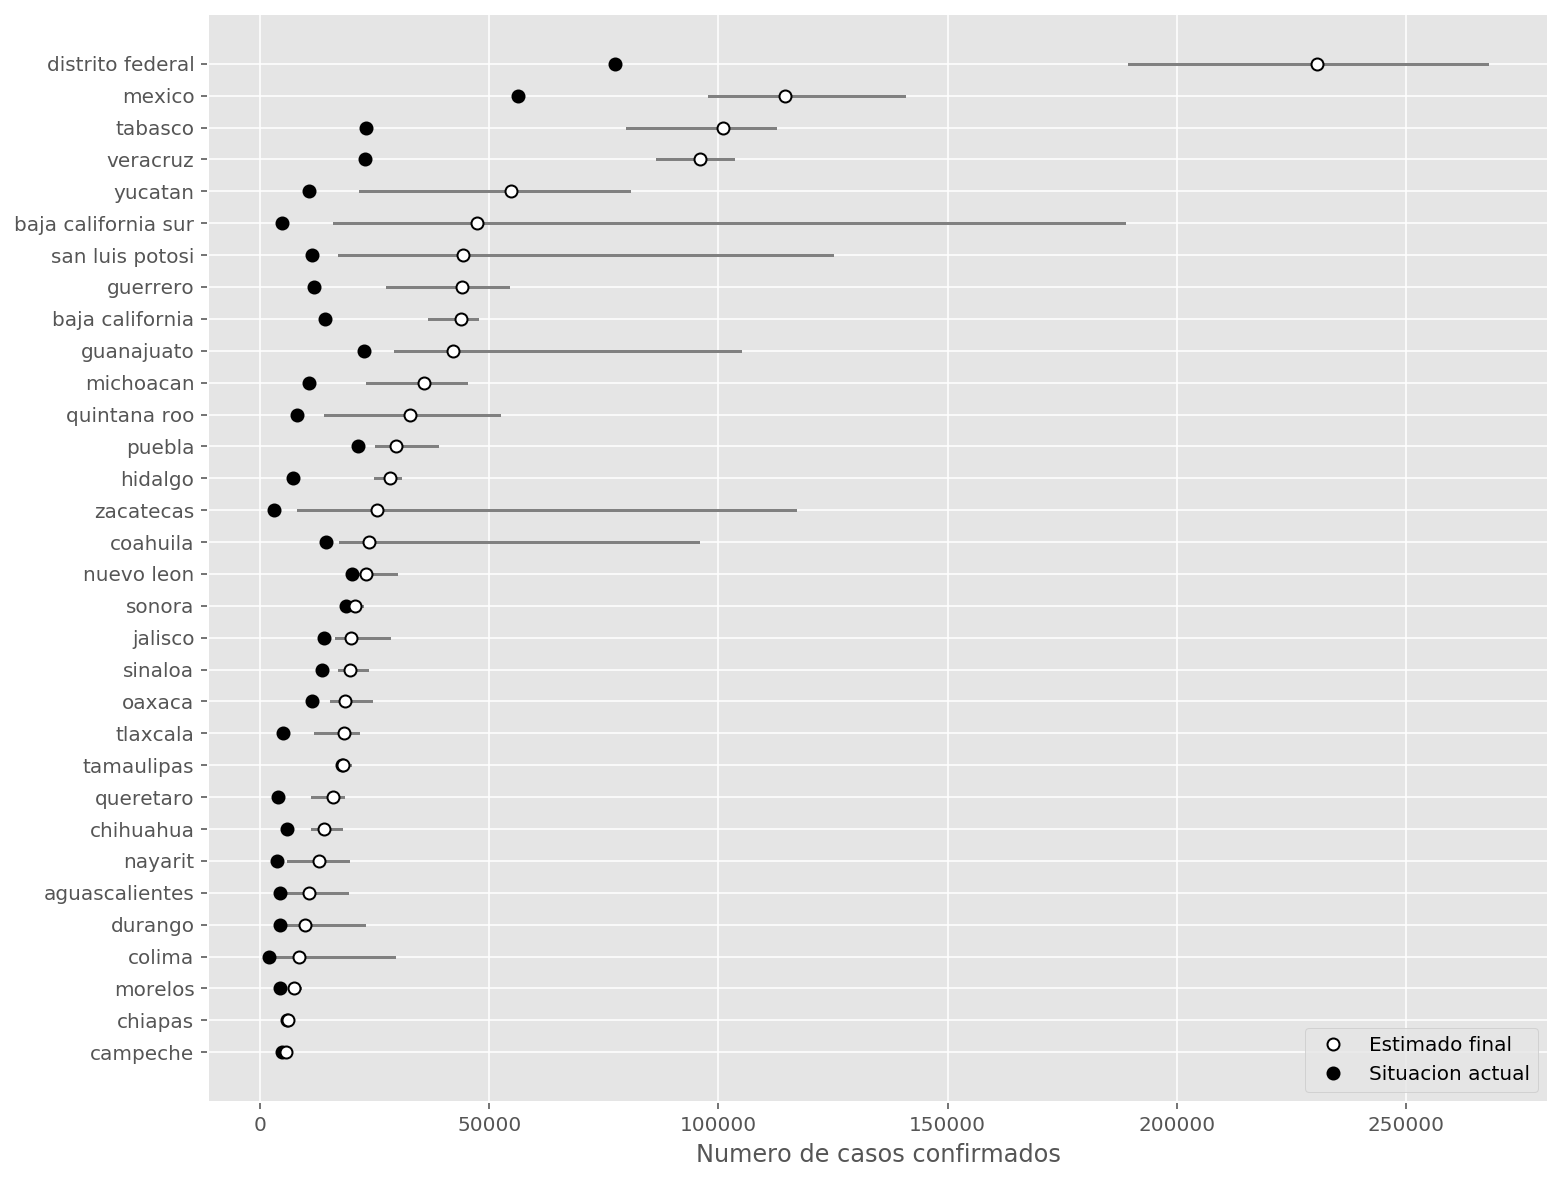

In [293]:
f = plt.figure(figsize=(12, 10))
plt.plot(median_final_count[order], range(len(median_final_count)), marker='o', linestyle='none', color='k', markerfacecolor='white', zorder=100, label='Estimado final')
for n, (x1, x2) in enumerate(zip(lower_final_count[order], upper_final_count[order])):
    plt.plot([x1, x2], [n, n], color='gray', markerfacecolor='none')

plt.plot(data['y'][:, order].sum(axis=0), range(len(order)), marker='o', color='black', linestyle='none', label='Situacion actual')
plt.yticks(range(len(order)), [coords["state"][i].lower() for i in order])
# xticks = [0, 20_000, 40000, 60000, 80000, 100000]
# plt.xticks(xticks, [format(n, ",") for n in xticks])
plt.xlabel("Numero de casos confirmados")
plt.legend(loc='lower right')
plt.show()

In [295]:
y_samples_mex = samples.extract()['y_pred'].sum(axis=2)

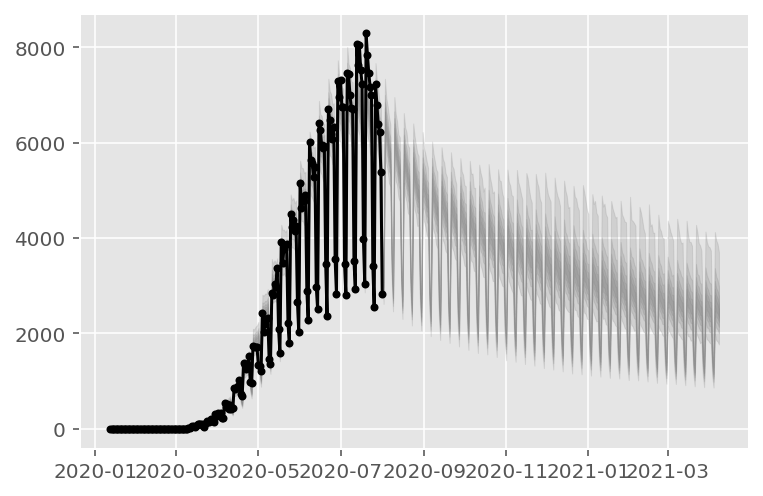

In [296]:
f, ax = plt.subplots()
tsplot(coords['forecast_date'], y_samples_mex[:, :], ax=ax, n=5)
ax.plot(coords['date'], data['y'].sum(axis=1), '.-', color='black')

In [297]:
samples.extract()['beta'].mean(axis=0)

array([0.04711378, 0.12593448, 0.0277941 , 0.0510095 , 0.09001274,
       0.12457695, 0.09612988, 0.042737  , 0.04323688, 0.0609047 ,
       0.06051087, 0.07546033, 0.07802823, 0.05346677, 0.09765861,
       0.07692673, 0.1197318 , 0.05161139, 0.04946292, 0.08220266,
       0.05240325, 0.06430436, 0.03124142, 0.04694316, 0.06024176,
       0.07302612, 0.05868672, 0.05259019, 0.0655989 , 0.08034273,
       0.037716  , 0.03497956])

In [299]:
1/np.exp(1)

0.36787944117144233

In [300]:
gamma = samples.extract()["gamma"]
S = samples.extract()["S"]

In [308]:
inflection = 1 - ((gamma + 1)**(-1/gamma))

In [309]:
inflection.mean(axis=0)

array([0.26360457, 0.02291729, 0.42250683, 0.54459163, 0.42789698,
       0.0923766 , 0.05643939, 0.51248168, 0.40096865, 0.29379112,
       0.37008322, 0.08935719, 0.02252425, 0.43737481, 0.15837894,
       0.09637518, 0.16650537, 0.20463468, 0.60382745, 0.28672891,
       0.44316892, 0.06503574, 0.27676103, 0.36626674, 0.34385185,
       0.46059419, 0.05068992, 0.62129938, 0.08523658, 0.02008637,
       0.22759483, 0.41835794])

In [310]:
inflection.mean(axis=0).argsort()

array([29, 12,  1, 26,  6, 21, 28, 11,  5, 15, 14, 16, 17, 30,  0, 22, 19,
        9, 24, 23, 10,  8, 31,  2,  4, 13, 20, 25,  7,  3, 18, 27])

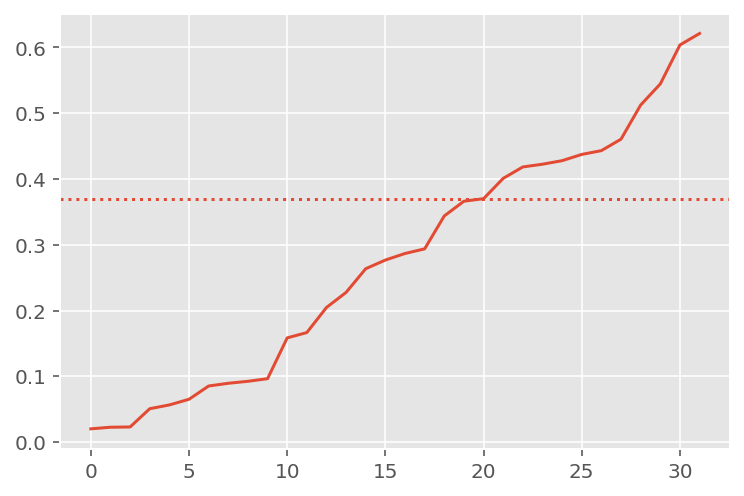

In [311]:
plt.plot(sorted(inflection.mean(axis=0)))
plt.axhline(y=0.37, linestyle=':')

# Inverted richards model

In [160]:
def richards(t, alpha, beta, gamma, S):
    return S / (1 + gamma * np.exp(-beta * (t - alpha)))**(1 / gamma)

def d_richards(t, alpha, beta, gamma, S):
    r = richards(t, alpha, beta, gamma, S)
    return (beta / gamma) * r * (1 - (r/S)**gamma)

def inverted_richards(t, alpha, beta, gamma, S):
    return S - richards(2*alpha - t, alpha, beta, gamma, S)

def d_inv_richards(t, alpha, beta, gamma, S):
    g = inverted_richards(t, alpha, beta, gamma, S)
    k = S - g
    return beta * k * (1 - (k / S)**gamma)

In [146]:
ts = np.arange(400)

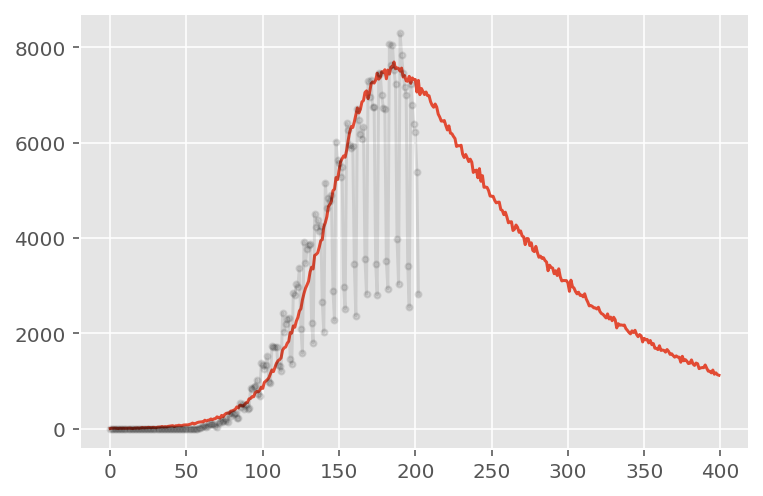

In [224]:
alpha = 185
beta = 0.049
gamma = 5
S = 0.0024
# pop = 3993508
pop = 110_000_000
args = (alpha, beta, gamma, S)
plt.plot(ts, np.random.poisson(pop * d_inv_richards(ts, *args)))
# plt.plot(ts, np.random.poisson(pop * d_richards(ts, *args)))
plt.plot(range(len(coords['date'])), data['y'].sum(axis=1), '.-', color='black', alpha=0.1)

# Save the samples

In [167]:
idata = arviz.from_pystan(
    samples,
    observed_data=['y', 'pop'],
    predictions=['y_pred', 'y_trend',],
    dims={
        'y': ['date', 'state'],
        'y_pred': ['forecast_date', 'state'],
        'y_trend': ['forecast_date', 'state'],
        'pop': ['state'],
        'alpha': ['state'],
        'beta': ['state'],
        'nu': ['state'],
        'S': ['state'],
        'phi': ['state'],
        "mu_theta": ["growth_parameter"],
        "sigma_theta": ["growth_parameter"],
        "log_theta": ["state", "growth_parameter"],
        'dow': ['day'],
    },
    coords={
        **coords,
        **{
            'day': [d.day_name() for d in coords['date'][:6]],
            'growth_parameter': ["alpha", "beta", "nu", "S"],
        }
    },
)

In [168]:
idata

Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data

In [198]:
idata.to_netcdf("./forecast_covid_mx.nc")

'./forecast_covid_mx.nc'

In [200]:
# Read in the saved samples
# arviz.InferenceData.from_netcdf('./forecast_covid_mx.nc')